## Segmentation of satellite images of water bodies

The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I used built-in Keras Sequential model with and without data augmentation technique to perform segmentation of satellite images of water bodies.

**1. Prepare Problem**

In [1]:
# a) Load libraries

from numpy import asarray

import cv2
import glob

from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# b) Load dataset

images = glob.glob("D:/PROJECTS/GitHub_Projects/Classification_Satellite_Images/Water_bodies/Images/all_classes/*.jpg")
masks = glob.glob("D:/PROJECTS/GitHub_Projects/Classification_Satellite_Images/Water_bodies/Masks/all_classes/*.jpg")

print(len(images), len(masks))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

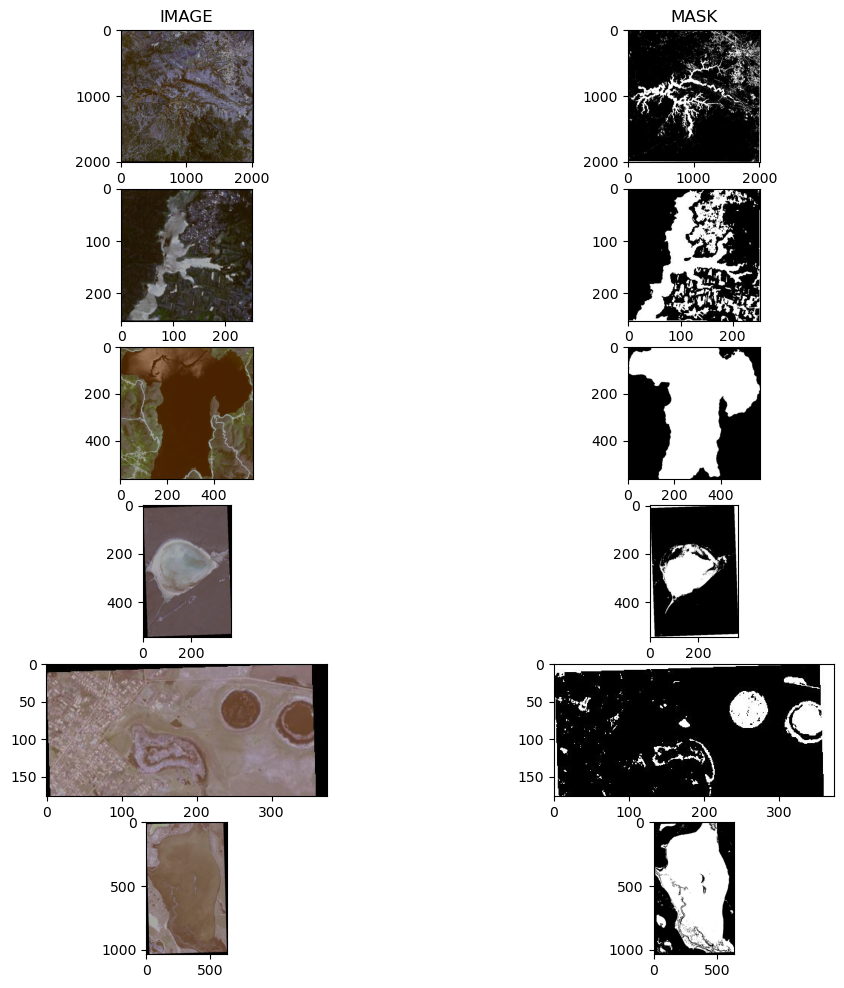

In [3]:
# a) Image visualization
# plot first few images in Images and Masks folder
f, axr = plt.subplots(6,2, figsize=(12,12))
i = 0 
for i in range(6):
    original = cv2.imread(images[i])
    mask = cv2.imread(masks[i])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different sizes and types.

In [4]:
# b) Load and resize all images in Images and Masks folders
df_images = []
for img in images:
#cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB 
    n = cv2.imread(img, cv2.COLOR_BGR2RGB)
    n = cv2.resize(n, (128, 128))
    df_images.append(n)
# Convert image into array of pixels
df_images = asarray(df_images)

df_masks = []
for msk in masks:
    m = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m, (128, 128))
    df_masks.append(m)
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2841 2841


**3. Prepare Data**

In [5]:
# a) Split data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2272, 128, 128, 3) (2272, 128, 128) (569, 128, 128, 3) (569, 128, 128)


In [6]:
# b) Data processing
# Flatten 128 x 128 images and convert data from numpy array to float type

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 128, 128).astype('float32')
y_test = y_test.reshape(y_test.shape[0], 128, 128).astype('float32')


In [7]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
y_train = y_train / 255
y_test = y_test / 255

**4. Evaluate Models**

The model we are going to use to segment images is a simple neural network with one hidden layer with the same number of neurons (16384) as the visible layer.

In [8]:
# a) Define Keras Sequential model

def base_model():
    model = Sequential()
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model

# Build the model
model = base_model()

In [9]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
71/71 [==============================] - 34s 479ms/step - loss: 0.3692 - val_loss: 0.3099
Epoch 2/50
71/71 [==============================] - 42s 600ms/step - loss: 0.2696 - val_loss: 0.2477
Epoch 3/50
71/71 [==============================] - 45s 633ms/step - loss: 0.2322 - val_loss: 0.2270
Epoch 4/50
71/71 [==============================] - 45s 640ms/step - loss: 0.2187 - val_loss: 0.2166
Epoch 5/50
71/71 [==============================] - 46s 651ms/step - loss: 0.2095 - val_loss: 0.2087
Epoch 6/50
71/71 [==============================] - 51s 714ms/step - loss: 0.2027 - val_loss: 0.2025
Epoch 7/50
71/71 [==============================] - 47s 664ms/step - loss: 0.1968 - val_loss: 0.1967
Epoch 8/50
71/71 [==============================] - 48s 684ms/step - loss: 0.1911 - val_loss: 0.1912
Epoch 9/50
71/71 [==============================] - 45s 636ms/step - loss: 0.1864 - val_loss: 0.1870
Epoch 10/50
71/71 [==============================] - 44s 625ms/step - loss: 0.1826 - val_lo

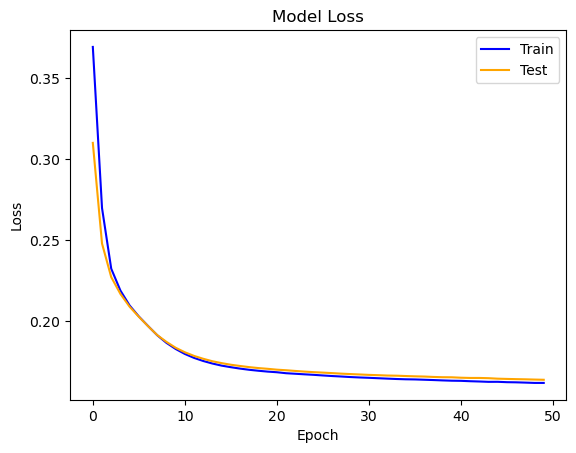

In [10]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

The loss values of training and validation are in good agreement and are reasonable for such a simple CNN model.

**4. Improved Baseline Models**

In this section, we aims at improving the baseline model by applying Dropout regularization and data augmentation.

In [11]:
# Create a generator that performs simple augmentation on the baseline image, 
# specifically horizontal flips and 10% shifts in the height and width of the images in train and test sets.

gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [12]:
# Prepare iterators for each dataset
train_gen = gen.flow(X_train, y_train, batch_size=32)
test_gen = gen.flow(X_test, y_test, batch_size=32)

In [13]:
# Define Keras Sequential model with a Dropout layer
def improved_model():
    model2 = Sequential()
    model2.add(Dense(200, activation='relu'))
    model2.add(Dropout(0.3))
    model2.add(Dense(1))
    model2.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model2

# Build the model
model2 = improved_model()

In [14]:
# Fit the model
history2 = model2.fit(train_gen, epochs=50, batch_size=32, validation_data=test_gen)

Epoch 1/50
71/71 [==============================] - 172s 2s/step - loss: 0.2932 - val_loss: 0.2606
Epoch 2/50
71/71 [==============================] - 170s 2s/step - loss: 0.2431 - val_loss: 0.2349
Epoch 3/50
71/71 [==============================] - 159s 2s/step - loss: 0.2297 - val_loss: 0.2269
Epoch 4/50
71/71 [==============================] - 155s 2s/step - loss: 0.2227 - val_loss: 0.2203
Epoch 5/50
71/71 [==============================] - 185s 3s/step - loss: 0.2177 - val_loss: 0.2157
Epoch 6/50
71/71 [==============================] - 171s 2s/step - loss: 0.2135 - val_loss: 0.2116
Epoch 7/50
71/71 [==============================] - 176s 2s/step - loss: 0.2101 - val_loss: 0.2084
Epoch 8/50
71/71 [==============================] - 171s 2s/step - loss: 0.2077 - val_loss: 0.2059
Epoch 9/50
71/71 [==============================] - 173s 2s/step - loss: 0.2059 - val_loss: 0.2044
Epoch 10/50
71/71 [==============================] - 188s 3s/step - loss: 0.2046 - val_loss: 0.2035
Epoch 11/

We can see that contrary to what we would have hoped of a further lift in model performance, the new model performs worse than the baseline one. 

Using both Dropout regularization and data augmentation techniques together hasn't improved model's performance which can be explained by (1) the shallowness of the CNN architecture, (2) the size and complexity of the dataset, and (3) possibly some extent of overfitting from the data augmentation.

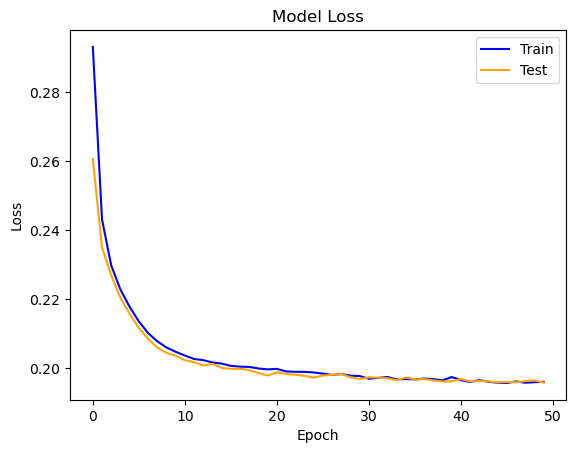

In [15]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

Since the new model underperforms the baseline one, we will use the baseline model for prediction and finalization.

**5. Finalize Model**

1/1 [==============================] - 1s 809ms/step


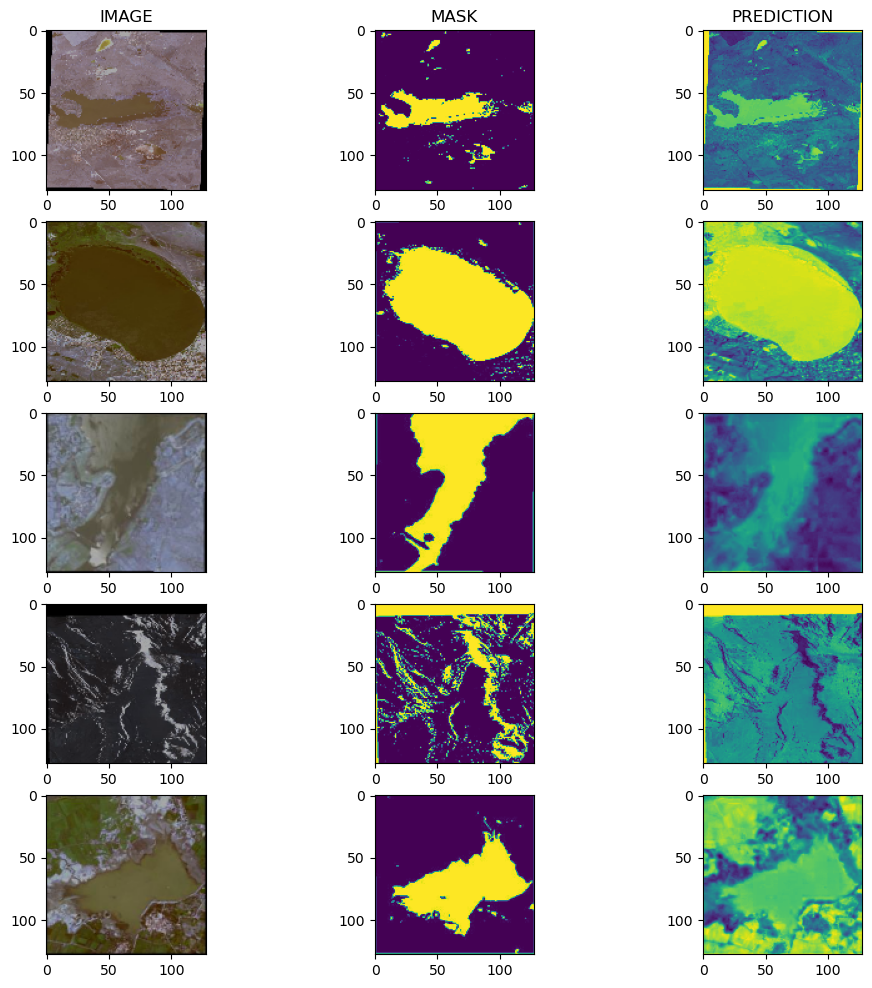

In [16]:
# a) Predictions on test data

preds = model.predict(X_test[:5])

# Plot original and predicted images
fig, ax = plt.subplots(5,3, figsize=(12,12))
i = 0 
for i in range(5):
    orig = X_test[i]
    msk = y_test[i]
    pred = preds[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk)
    ax[i,2].imshow(pred)
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

Overall, the predicted images capture mostly large and clear-shaped water bodies. However, further improvement by using a larger and pre-trained model might allow the model to predict features with relatively small and irregular shapes.

In [17]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://75c45fff-2277-4dd9-bc49-8fdb88e45b89/assets


**6. Conclusions**

- The image needs to be preprocessed (resize, normalize) properly before passing into the CNN model for segmentation.

- Satellite image introduce additional challenges, such as different sizes, resolutions, and details of objects to be detected, compared to common images.

- A simple CNN model with one hidden layer can detect and reproduce the shape of most water bodies in the image and mask dataset.

- The use of Dropout regularization and data augmentation doesn't improve the performance of the model owing to the shallowness of the CNN architecture, the size and complexity of the dataset, and possibly some extent of overfitting from the data augmentation.

- The model performance can be improved by using large and pre-trained models (such as ResNet-50) and will be covered in the second Notebook of this repository.